## Image Classification Project by ABBOUDI Mohammed Amine
13/10/2018

Dans ce notebook, je vais mettre en pratique les differentes techniques de réduction de dimension de jeu de données, ainsi que l'extraction de Featues en ce qui concerne des données images.
Ce projet a pour objet de classifier des boites de conserves prises en photo depuis une chaine de production. Le modèle doit determiner si la boite est défectueuse ou non.

Je procèderai par la démarche suivante
    - Lecture des Données .mat
    - Test de classifieurs (Régression Logistique, Random Forrest, SVC, KNN, Naive Bayes...)
    - Test de techniques de réduction de dimension (Kernel PCA, LLE, MDS, ISOMAP)
    - Test d'extracteurs de Features (Canny, HOG et HAAR Wavelet Transform)
    - Application du meilleur classifieur, reducteur de dimension, et extracteur de Features.
    - Comparaison avec un Réseau Convolution de Neurones basé sur Tensorflow et interfacé avec Keras.

In [1]:
#Importation des librairies necessaires

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from scipy import ndimage as ndi
from skimage import feature, io
from scipy import misc
import glob
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import RandomizedSearchCV


from scipy.io import loadmat

import warnings
warnings.filterwarnings("ignore")

### Lecture des données

In [2]:
df = loadmat('DB_Grayscale_Clean_18k.mat')
df

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Oct 11 20:45:02 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Features': array([[163, 158, 160, ..., 171, 179, 178],
        [165, 159, 159, ..., 171, 178, 170],
        [161, 161, 160, ..., 172, 173, 175],
        ...,
        [154, 164, 154, ..., 170, 166, 178],
        [157, 163, 154, ..., 170, 166, 178],
        [154, 157, 155, ..., 170, 166, 180]], dtype=uint8),
 'Labels': array([[1, 0, 1, ..., 0, 0, 1]], dtype=uint8)}

In [3]:
X = df['Features'].transpose()
y = df['Labels'].transpose()
X.shape

(2042, 18615)

Nous avons 2042 images, avec une resolution de 18k pixels

### Affichage des Images

In [4]:
# Transformation du vecteur de pixels en matrice 2D

X = X.reshape(-1,219,85)
X.shape

(2042, 219, 85)

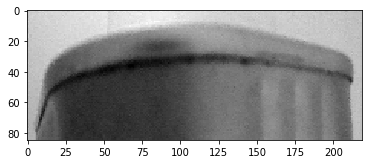

In [5]:
# Affichage de la première image
plt.imshow(X[200].transpose(), cmap='gray')
plt.show()

In [6]:
X_flat = pd.DataFrame()

for i in range(X.shape[0]):
    X_flat[i] = X[i].flatten()
X1 = X_flat.transpose()

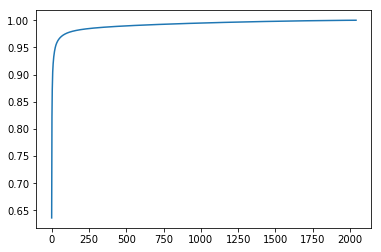

In [7]:
pca = PCA()
pca.fit(X1).transform(X1)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

On remarque que 80 variables sont suffisantes pour expliquer 99% de la variance. On peut se limiter à cela pour la réduction de dimension dans ce qui suivra.

## No Feature Extraction, No Dimentionality Reduction

In [ ]:
X_train1, X_test1,y_train1,y_test1 = train_test_split(X1, y, test_size=0.3)

#### Baseline

In [ ]:
len([x for x in y if x==1])/len(y)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit1=LogisticRegression()
logit1.fit(X_train1,y_train1)

print(logit1.score(X_test1,y_test1))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit1.predict(X_test1)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [ ]:
start_time = time.time()

rf1 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 2)
rf1.fit(X_train1, y_train1)

print(rf1.score(X_test1,y_test1))
print("--- %s seconds ---" % (time.time() - start_time))

#### K-Nearest Neighbors

In [ ]:
start_time = time.time()

knn1 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn1.fit(X_train1, y_train1)

print(knn1.score(X_test1,y_test1))
print("--- %s seconds ---" % (time.time() - start_time))

#### Naive Bayes

In [ ]:
start_time = time.time()

nb1 = GaussianNB()
nb1.fit(X_train1, y_train1)

print(nb1.score(X_test1,y_test1))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = nb1.predict(X_test1)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc1 = SVC()
svc1.fit(X_train1, y_train1)

print(svc1.score(X_test1,y_test1))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = svc1.predict(X_test1)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Dimentionality Reduction Only

Puisque le jeu de données est nonlinéaire (Images), il est évident d'utiliser une technique de réduction de dimension qui agit sur des données du même type

In [ ]:
X2 = X1.copy()

### Kernel PCA

In [ ]:
kpca2 = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10, n_components = 80)
X2_kpca = kpca2.fit_transform(X2)
X2_kpca.shape

In [ ]:
X_train2, X_test2,y_train2,y_test2 = train_test_split(X2_kpca, y, test_size=0.3, random_state=2)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit2=LogisticRegression()
logit2.fit(X_train2,y_train2)

print(logit2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit2.predict(X_test2)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 2)
rf2.fit(X_train2, y_train2)

print(rf2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc2 = SVC()
svc2.fit(X_train2, y_train2)

print(svc2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

### Locally Linear Embedding

In [ ]:
lle2 = LocallyLinearEmbedding(n_neighbors = 200, n_components = 80, eigen_solver='auto', 
                         method='modified')
X2_lle = lle2.fit_transform(X2)
X2_lle.shape

In [ ]:
X_train2, X_test2,y_train2,y_test2 = train_test_split(X2_lle, y, test_size=0.3, random_state=2)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit2=LogisticRegression()
logit2.fit(X_train2,y_train2)

print(logit2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit2.predict(X_test2)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 2)
rf2.fit(X_train2, y_train2)

print(rf2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc2 = SVC()
svc2.fit(X_train2, y_train2)

print(svc2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

les trois meilleurs modèles ont maintenant le même score de 0.75 qui est le baseline, donc, on est de retour à la case de départ. D'une autre part on remarque une grande diminution du temps de calcul.

## ISOMAP

In [ ]:
iso2 = Isomap(n_neighbors = 300, n_components = 80)
X2_iso = iso2.fit_transform(X2)
X2_iso.shape

In [ ]:
X_train2, X_test2,y_train2,y_test2 = train_test_split(X2_iso, y, test_size=0.3, random_state=2)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit2=LogisticRegression()
logit2.fit(X_train2,y_train2)

print(logit2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit2.predict(X_test2)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf2.fit(X_train2, y_train2)

print(rf2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc2 = SVC()
svc2.fit(X_train2, y_train2)

print(svc2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

## Multi Dimentional Scaling

In [ ]:
mds2 = MDS(n_components = 80, max_iter=100, n_init=1)
X2_mds = mds2.fit_transform(X2)
X2_mds.shape

In [ ]:
X_train2, X_test2,y_train2,y_test2 = train_test_split(X2_mds, y, test_size=0.3, random_state=2)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit2=LogisticRegression()
logit2.fit(X_train2,y_train2)

print(logit2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit2.predict(X_test2)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forrest

In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf2.fit(X_train2, y_train2)

print(rf2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc2 = SVC()
svc2.fit(X_train2, y_train2)

print(svc2.score(X_test2,y_test2))
print("--- %s seconds ---" % (time.time() - start_time))

On arrive à un résultat légèrement supérieur au modèle baseline. Mais il reste inférieur au meilleur modèle de régression logistique.

# Feature Extraction Only

In [ ]:
X3 = X.copy()

## Canny Edge

In [ ]:
X3_canny = X3.copy()
for i in range(X3.shape[0]):
    im = X3[i].transpose()
    canny = feature.canny(im, sigma=1)
    X3_canny[i] = canny.transpose()

In [ ]:
X3_canny_flat = pd.DataFrame()

for i in range(X3_canny.shape[0]):
    X3_canny_flat[i] = X3_canny[i].flatten()
X3_canny_flat = X3_canny_flat.transpose()

#### Régression Logistique

In [ ]:
X_train3, X_test3,y_train3,y_test3 = train_test_split(X3_canny_flat, y, test_size=0.3, random_state=2)

In [ ]:
start_time = time.time()

logit3=LogisticRegression()
logit3.fit(X_train3,y_train3)

print(logit3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit3.predict(X_test3)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forrest

In [ ]:
start_time = time.time()

rf3 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf3.fit(X_train3, y_train3)

print(rf3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc3 = SVC()
svc3.fit(X_train3, y_train3)

print(svc3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

On ne voit aucun un degradation de la performance des modeèle, à part le SVC qui maintient le modèle Baseline.

## Histogram of Oriented Gradients

In [ ]:
X3_hog = X3.copy()

for i in range(X3.shape[0]):
    im = X3[i]
    fd, hog_image = hog(im, orientations=16, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), visualize=True)

    X3_hog[i] = exposure.rescale_intensity(hog_image, in_range=(0, 10))

In [ ]:
X3_hog_flat = pd.DataFrame()

for i in range(X3_hog.shape[0]):
    X3_hog_flat[i] = X3_hog[i].flatten()
X3_hog_flat = X3_hog_flat.transpose()

#### Régression Logistique

In [ ]:
X_train3, X_test3,y_train3,y_test3 = train_test_split(X3_hog_flat, y, test_size=0.3)

In [ ]:
start_time = time.time()

logit3=LogisticRegression()
logit3.fit(X_train3,y_train3)

print(logit3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit3.predict(X_test3)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forrest

In [ ]:
start_time = time.time()

rf3 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf3.fit(X_train3, y_train3)

print(rf3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc3 = SVC()
svc3.fit(X_train3, y_train3)

print(svc3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

In [8]:
X3_hog_prof = loadmat('DB_HOG_Clean_18k.mat')

In [9]:
y_hog_prof = X3_hog_prof['Labels'].transpose()
X3_hog_prof = X3_hog_prof['Features'].transpose()

In [19]:
X_train3, X_test3,y_train3,y_test3 = train_test_split(X3_hog_prof, y, test_size=0.05, shuffle = False)

#### Régression Logistique

In [20]:
start_time = time.time()

logit3=LogisticRegression()
logit3.fit(X_train3,y_train3)

print(logit3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

0.9320388349514563
--- 5.016822099685669 seconds ---


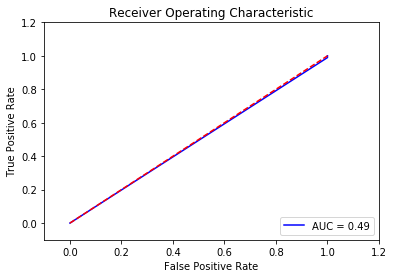

In [21]:
y_pred = logit3.predict(X_test3)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test3, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forrest

In [22]:
start_time = time.time()

rf3 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf3.fit(X_train3, y_train3)

print(rf3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

0.941747572815534
--- 12.761481046676636 seconds ---


#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc3 = SVC()
svc3.fit(X_train3, y_train3)

print(svc3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
## Wavelet Transform

In [ ]:
X3_haar_prof = loadmat('DB_Haar_Clean_18k.mat')

In [ ]:
y_haar_prof = X3_haar_prof['Labels'].transpose()
X3_haar_prof = X3_haar_prof['Features'].transpose()

In [ ]:
X_train3, X_test3,y_train3,y_test3 = train_test_split(X3_haar_prof, y, test_size=0.35)

#### Régression Logistique

In [ ]:
start_time = time.time()

logit3=LogisticRegression()
logit3.fit(X_train3,y_train3)

print(logit3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
y_pred = logit3.predict(X_test3)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test3, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forrest

In [ ]:
start_time = time.time()

rf3 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy')
rf3.fit(X_train3, y_train3)

print(rf3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

#### Support Vector Classifier

In [ ]:
start_time = time.time()

svc3 = SVC()
svc3.fit(X_train3, y_train3)

print(svc3.score(X_test3,y_test3))
print("--- %s seconds ---" % (time.time() - start_time))

# Modèle Final: 
#### LLE pour la réduction de dimension, HOG pour extraire les Features et La Régression Logistique pour prédire

In [17]:
X4 = X3_hog_prof.copy()
y4 = y_hog_prof

In [18]:
lle4 = LocallyLinearEmbedding(n_neighbors = 2000, n_components = 1000, eigen_solver='auto', 
                         method='modified')
X4_lle = lle4.fit_transform(X2)
X4_lle.shape

NameError: name 'X2' is not defined

In [ ]:
X_train4, X_test4,y_train4,y_test4 = train_test_split(X4_lle, y, test_size=0.35,)

In [ ]:
param_grid = {'C':[0.001,0.01,0.1,1,5,10],'penalty':['l1','l2']}
randsearch = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, cv=5, n_jobs=4,
                                    verbose=1, n_iter=1000)
randsearch.fit(X_train4,y_train4)
randsearch.score(X_test4,y_test4)

In [ ]:
X_train4, X_test4,y_train4,y_test4 = train_test_split(X, y, test_size=0.35)

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


classifier = Sequential()

classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))

classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())  

classifier.add(Dense(output_dim = 128, activation = 'relu'))

classifier.add(Dense(output_dim = 3, activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

(X_train4, y_train4), (X_test4, y_test4) = cifar100.load_data(label_mode='fine')



In [ ]:
model1 = classifier.fit_generator(training_set,
                         samples_per_epoch = 2400,
                         nb_epoch = 20,
                         validation_data = test_set,
                         nb_val_samples = 800, verbose = 1, steps_per_epoch=None)